In [1]:
import numpy as np
import pandas as pd
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

# Initialize OpenAI for Pong
env = gym.make("Pong-v0")

# Hyper parameters for policy gradient model
global num_actions, discount
num_actions = 3 
discount = 0.99
save_every = 10
train_every = 1
reward_factor = 1
max_episode = 30001

# Hyper parameters for Network
learning_rate=0.0005
FC_param = {'FC_1':200}
decay_ = 0.95
epsilon_ = 1e-8

# Initialize parameter for policy gradient model 
observation = env.reset()
image_old  = None
images, fake_labels, rewards_std, action_hist, reward_hist, reward_runn = [], [], [], [], [], []
reward_episode = 0

# Build network
def Network(image_, FC_param):
    
    FC_tmp = tf.contrib.layers.flatten(image_, scope='Flatten')
    
    for key,value in FC_param.items():
        FC_tmp = tf.layers.dense(inputs=FC_tmp, 
                                 units=value,
                                 kernel_initializer= tf.truncated_normal_initializer(mean=0,
                                                                                     stddev=1./np.sqrt(5000), 
                                                                                     dtype=tf.float32),
                                 activation=tf.nn.relu,
                                 use_bias=False,
                                 name=key)
    
    logits = tf.layers.dense(inputs=FC_tmp, 
                             units=num_actions, 
                             kernel_initializer= tf.truncated_normal_initializer(mean=0,
                                                                                 stddev=1./np.sqrt(500), 
                                                                                 dtype=tf.float32),
                             use_bias=False,
                             name='Logits')
    
    action_probs = tf.nn.softmax(logits, name='SoftMax')
    
    return action_probs

# Get discounted reward and normalize it
def discount_norm(rew):
    rew_func = lambda a, v: a*discount + v # Reward function
    
    rew_reverse = tf.scan(rew_func, tf.reverse(rew,[True, False]))
    discounted_rew = tf.reverse(rew_reverse,[True, False])
    
    mean, variance= tf.nn.moments(discounted_rew, [0])
    discounted_rew -= mean
    discounted_rew /= tf.sqrt(variance + 1e-6)
    
    return discounted_rew

# Process image by cropping and binarizing
def process_obs(obs):
    obs = obs[35:195]
    obs = obs[::2,::2,0]
    obs[obs == 144] = 0
    obs[obs == 109] = 0
    obs[obs != 0] = 1 
    return obs.astype(np.float)

# Break down into batch jobs to reduce GPU/CPU load
def gen_batch_index(num_of_steps):
    batch_index = []
    start = 0
    for index in np.array(range(0,len(images),batch_size)):
        end=index
        if end > 0:
            batch_index.append([start,end])
        start=index
    end = len(images)
    batch_index.append([start,end])
    return batch_index

def get_running_mean(reward_hist):
    
    running_mean=[]
    mean=-21
    for i in range(len(reward_hist)):
        mean = 0.99*mean + 0.01*reward_hist[i]
        running_mean.append(mean)
        
    return running_mean

# Build model
with tf.Graph().as_default() as g:
    with tf.device("/cpu:0"):
        image_ = tf.placeholder(dtype=tf.float32, shape=[None, 80,80,1],name="image")
        fake_label_ = tf.placeholder(dtype=tf.float32, shape=[None, num_actions],name="fake_label")
        reward_ = tf.placeholder(dtype=tf.float32, shape=[None,1], name="reward")

        discounted_epr = discount_norm(reward_) # Get policy gradient

        tf_aprob = Network(image_,FC_param)
        loss = tf.nn.l2_loss(fake_label_-tf_aprob) # Define loss
        optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=decay_, epsilon=epsilon_)
        grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), grad_loss=discounted_epr)
        train_op = optimizer.apply_gradients(grads)

# Main program
with g.as_default(), tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    saver = tf.train.Saver(tf.global_variables())
    
    # Load from last session or start over
    try:
        episode_number = pickle.load(open('PG-Pong-ckpt-1/last-episode.p','rb'))
        saver.restore(sess, 'PG-Pong-ckpt-1\\Pong_PG.ckpt-'+str(episode_number))
        reward_hist = pickle.load(open('PG-Pong-ckpt-1/all_reward.p','rb'))
        print('Continue from last saved episode')
    except:
        print('Training from beginning')
        episode_number = 0
        
    # Starting playing
    while episode_number <= max_episode:
    #     if True: env.render()
        image_proc = process_obs(observation)
        image_diff = image_proc - image_old if image_old is not None else np.zeros((80,80))
        image_old = image_proc

        # Uniformly pick an action
        feed_step = {image_: np.reshape(image_diff, (1,80,80,1))}
        aprob = sess.run(tf_aprob,feed_step) ; aprob = aprob[0,:]
        action = np.random.choice(num_actions, p=aprob)
        label = np.zeros_like(aprob) ; label[action] = 1

        # Input action to OpenAI and get feedback
        observation, reward, done, info = env.step(action+1)
        reward_episode += reward

        # Record for training
        images.append(image_diff); fake_labels.append(label); rewards_std.append(reward); action_hist.append(action+1)

        # Training
        if done:
            
            if episode_number % train_every == 0:
                
                feed_episode = {image_: np.array(images).reshape(-1, 80, 80, 1), 
                        fake_label_: np.array(fake_labels).reshape(-1,num_actions), 
                        reward_: np.array([i*reward_factor for i in rewards_std]).reshape(-1,1)}
                sess.run(train_op,feed_episode)
                    
                # Clear memory
                episode_duration = len(rewards_std)
                images, fake_labels, rewards_std, action_hist = [], [], [], []
            
            # Bookkeeping
            reward_hist.append(reward_episode)
            reward_runn.append(reward_episode)
            episode_number += 1
            observation = env.reset()
            print('\tep {}: reward: {} duration: {}'.format(episode_number, reward_episode,episode_duration))
            reward_episode = 0
            
            # Save model
            if episode_number % save_every == 0:
                saver.save(sess, 'PG-Pong-ckpt-1/Pong_PG.ckpt', global_step=episode_number)
                print('Model saved, mean reward is',np.mean(reward_runn))
                pickle.dump(episode_number,open('PG-Pong-ckpt-1/last-episode.p','wb'))
                pickle.dump(reward_hist,open('PG-Pong-ckpt-1/all_reward.p','wb'))
                
                plt.figure(figsize=(18,3))
                plt.plot([7]*(len(reward_hist)),'r--')
                plt.plot(np.array(get_running_mean(reward_hist)))
                plt.show()
                reward_runn = []


[2017-05-04 17:51:00,557] Making new env: Pong-v0


Continue from last saved episode


KeyboardInterrupt: 

G:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=200,center=False).mean()
G:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=200,center=False).var()


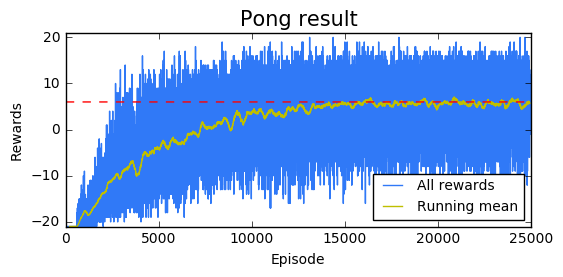

In [2]:
# Plotting
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 20))
interval = 200

new_reward_hist = [-21]*600
new_reward_hist.extend(reward_hist)

def get_mean_var(reward_hist):
    ts = pd.Series(reward_hist)
    return pd.rolling_mean(ts, interval), pd.rolling_var(ts, interval)

running_mean, running_var = get_mean_var(new_reward_hist)

plt.figure(figsize=(6,2.5))
plt.title('Pong result',fontsize=15)
plt.ylim(-21,21)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.plot(np.array(new_reward_hist),label='All rewards',c=colors[3,:])
plt.plot(np.array(running_mean),'y',label='Running mean')
plt.plot([6]*len(running_mean),'r--')
plt.legend(loc=4,fontsize=10)
plt.savefig('PG-Pong-ckpt-1/ANN1.jpg')
plt.show()